# Exploratory data analysis

## 0. Install dependencies

In [217]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### 0.1 Download dataset

In [4]:
od.download("https://www.kaggle.com/c/airbus-ship-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tymofiij
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 28.6G/28.6G [57:42<00:00, 8.86MB/s]



Extracting archive .\airbus-ship-detection/airbus-ship-detection.zip to .\airbus-ship-detection


## 1. Observe the data

**After downloading the dataset we need to examine our data. From Kaggle data page of this competition it is known that the dataset consists of 3 files: test images, train images and train_ship_segmentations.csv. The csv file provides the ground truth (in run-length encoding format) for the training images. Now lets observe the dataset!**<br>
Things to remember when we work with image segmentation: <br>
-Disable augmentation <br>
-Avoid destructive resizing <br>
-Always inspect the outputs visually

Get paths of the data

In [218]:
data_path = './airbus-ship-detection/' # directory of the data
train_csv ='./airbus-ship-detection/train_ship_segmentations_v2.csv'  # Path to the CSV train file 
test_dir = data_path+'test_v2/' # Directory where the test images are currently located
train_dir = data_path+'train_v2/' # Directory where the train images are currently located

Discover the csv file structure

In [269]:
df = pd.read_csv(train_csv)     
df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Encoded pixels are ground truth segmentation for provided image.<br>
Pixels are encoded in "Run-length encoding"<br>
(https://www.youtube.com/watch?v=Yl50cJScObI)

### 1.1 Display image and segmentation

In [220]:
def decode_run_length(encoded_coordinates):
    pixel_numbers = []
    pixel_number = np.array(encoded_coordinates[::2])
    pixel_amount = np.array(encoded_coordinates[1::2])
    
    for i in range(len(pixel_amount)):
        for j in range(pixel_number[i], pixel_number[i] + pixel_amount[i]):
            pixel_numbers.append(j)

    pixel_numbers = np.array(pixel_numbers)
    
    return pixel_numbers

In [221]:
def plot_image(index):
    '''
    display the image
    param index: index of the dataset row
    '''
    # ImageId - column with path to the image in the training directory
    # EncodedPixels - column with run-length encoded pixels of the ship
    
    if (not pd.isna(df.loc[index, 'EncodedPixels'])):
        ship_encoded_pixels = list(df.loc[index, 'EncodedPixels'].split())
        ship_encoded_pixels = [int(x) for x in ship_encoded_pixels]
        image_path = train_dir + df.loc[index, 'ImageId']
        image = Image.open(image_path)
        pixel_numbers = decode_run_length(ship_encoded_pixels)
        
        x, y = np.unravel_index(pixel_numbers - 1, image.size[:2])
        
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(131)
        plt.imshow(image)
        plt.title('Original Image')
        plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)

        # Segmented ship
        plt.subplot(132)
        plt.imshow(image)
        plt.scatter(x, y, color='red', marker='.')
        plt.title('Segmented ship')
        plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)

        plt.tight_layout()
        plt.show()
    else:
        image_path = train_dir + df.loc[index, 'ImageId']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title('Image without Ship')
        plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
        plt.show()


Image observation

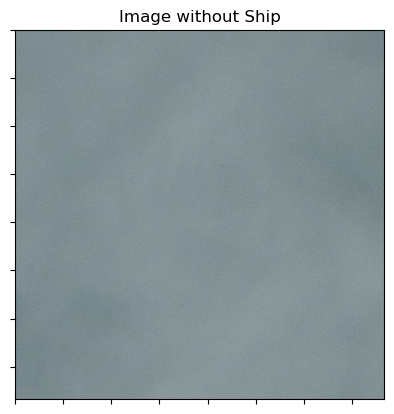

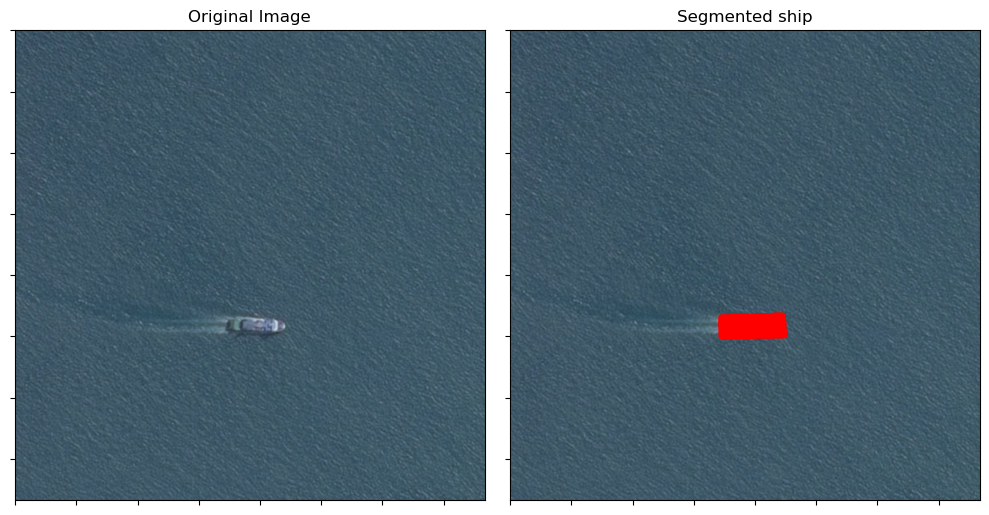

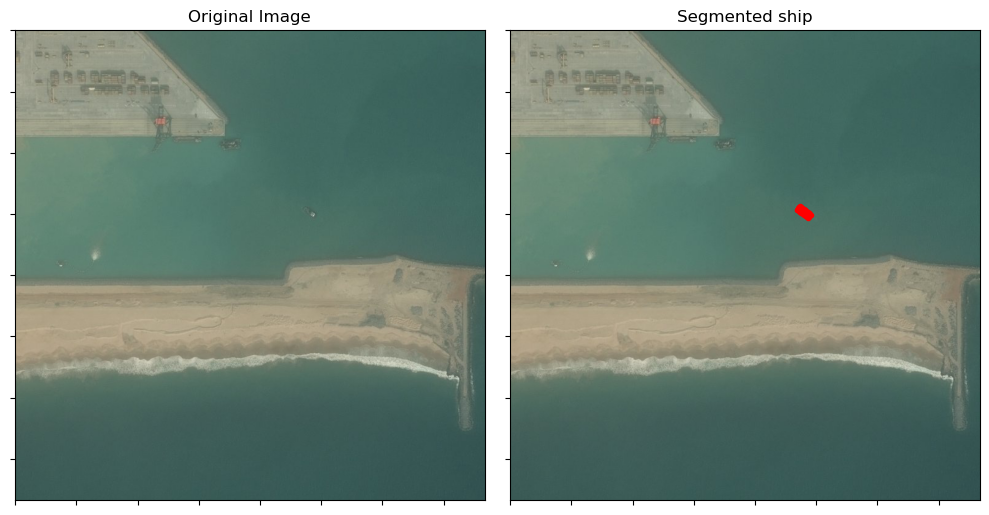

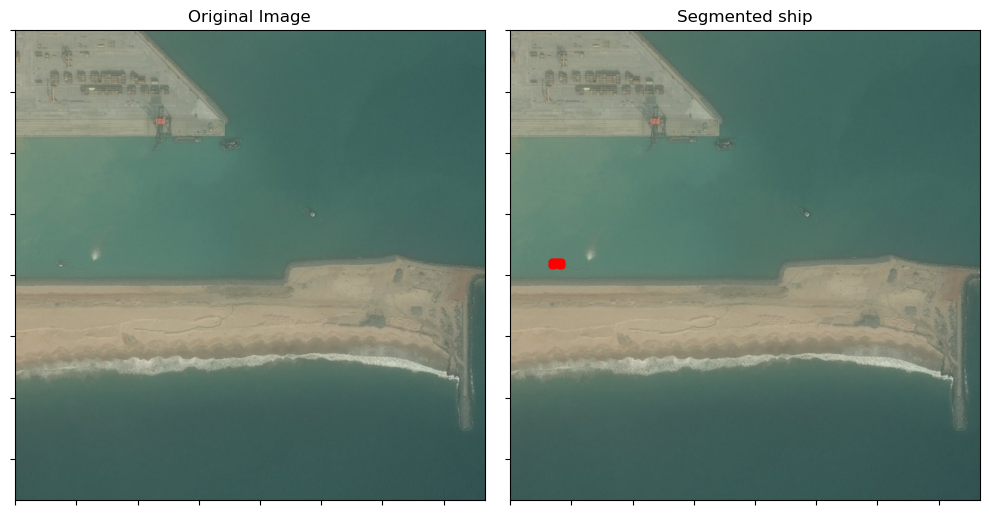

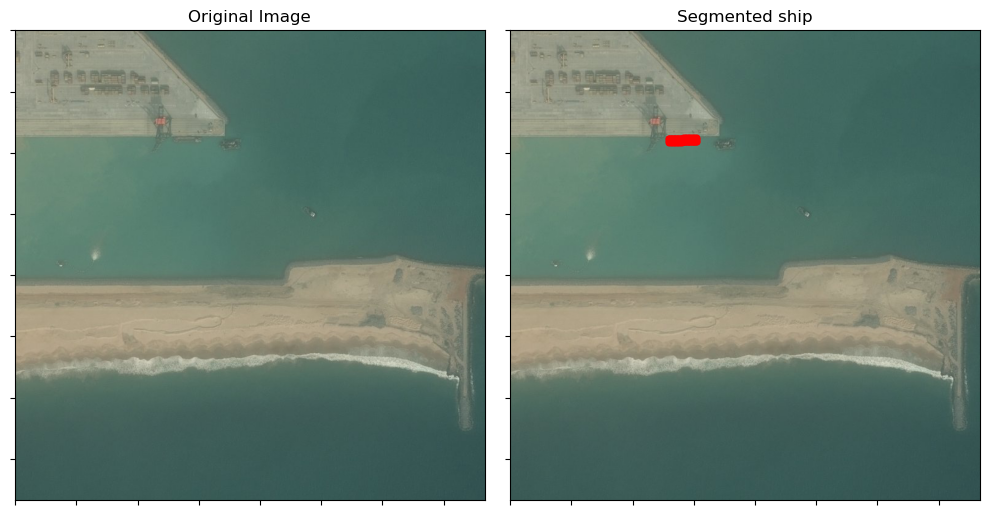

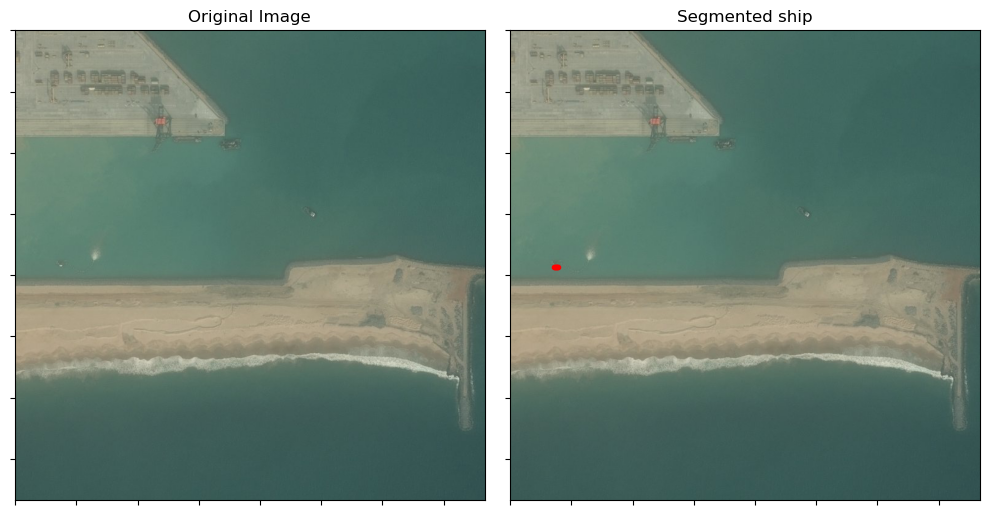

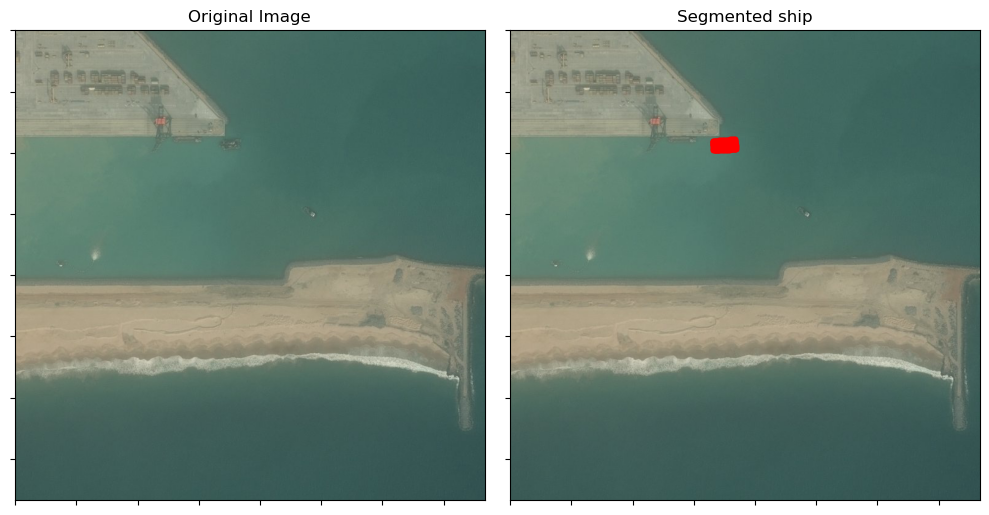

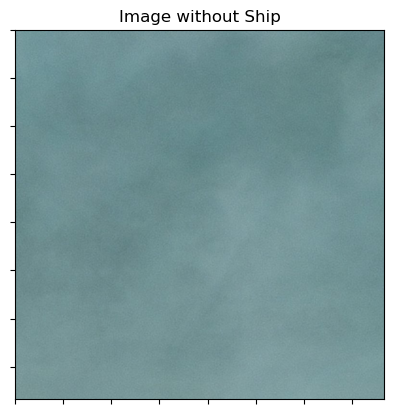

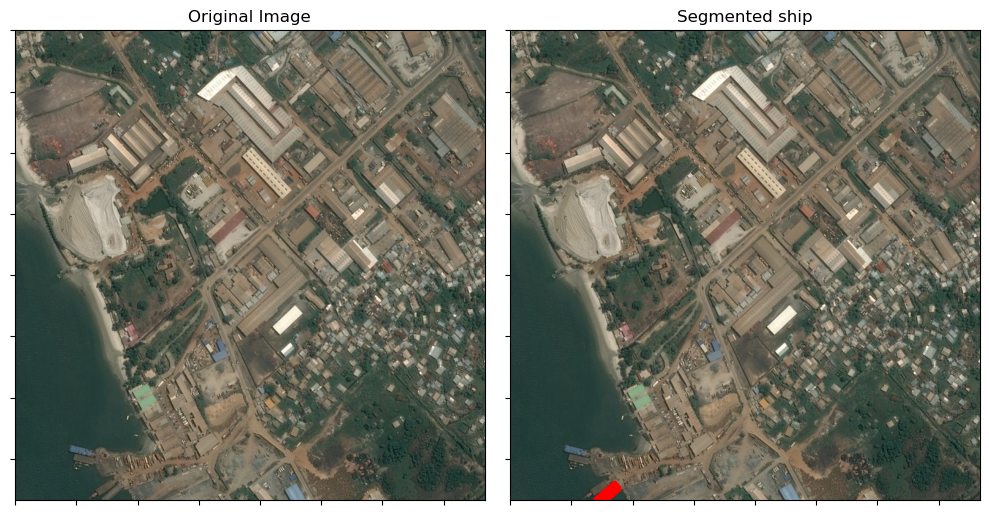

In [283]:
indexes = range(1,10)
for i in indexes:
    plot_image(i)

### 1.2 Explore images' shape

In [40]:
sizes = []
for image in os.listdir(train_dir):
    image = plt.imread(train_dir+image)
    sizes.append(image.shape)

In [42]:
widths = [shape[0] for shape in sizes]
heights = [shape[1] for shape in sizes]
dimensions = [shape[2] for shape in sizes]

width_counts = dict(zip(*np.unique(widths, return_counts=True)))
height_counts = dict(zip(*np.unique(heights, return_counts=True)))
dimension_counts = dict(zip(*np.unique(dimensions, return_counts=True)))

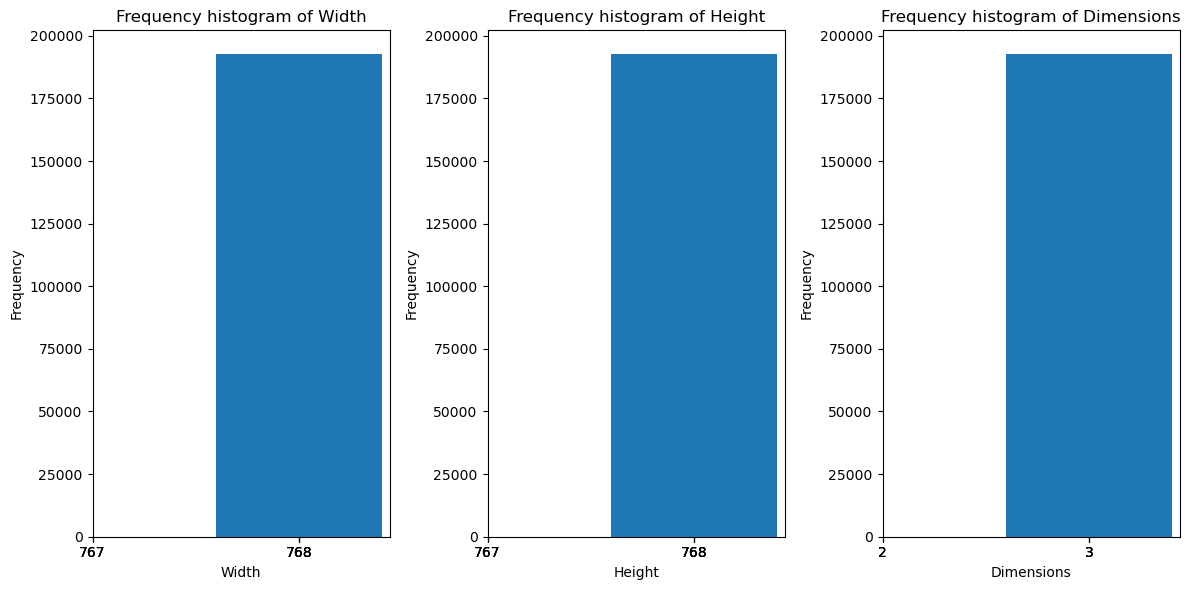

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.bar(width_counts.keys(), width_counts.values())
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Width')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.subplot(132)
plt.bar(height_counts.keys(), height_counts.values())
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Height')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.subplot(133)
plt.bar(dimension_counts.keys(), dimension_counts.values())
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Dimensions')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.tight_layout()

All the images are the same width, height and dimension

### 1.3 Analyse data

During the image observation we can see that some images contain 0 ships, some 1 and more.<br>
Let's dig into the data and showcase the findings in numbers and visualizations

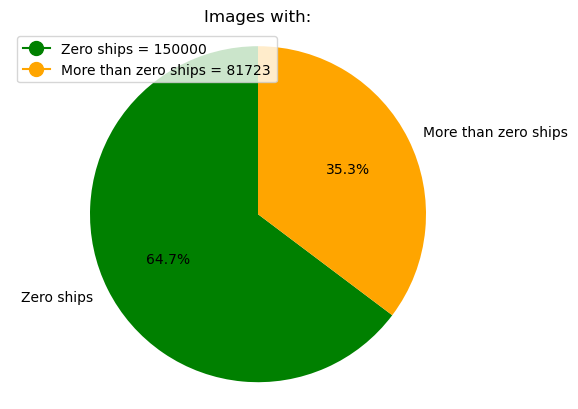

In [184]:
zero_ships = df['EncodedPixels'].isna().sum()
non_zero_ships = df.shape[0] - zero_ships

labels = ['Zero ships', 'More than zero ships']
sizes = [zero_ships, non_zero_ships]

fig, ax = plt.subplots()

pie_wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'orange'])
ax.axis('equal') 

legend_labels = [f'Zero ships = {zero_ships}', f'More than zero ships = {non_zero_ships}']
legend_handles = [plt.Line2D([0], [0], marker='o', color=color, label=label,
                            markerfacecolor=color, markersize=10) for color, label in zip([wedge.get_facecolor() for wedge in pie_wedges], legend_labels)]
plt.legend(handles=legend_handles, loc='upper left')
plt.title("Images with:")
plt.show()

In [279]:
duplicates_with_nan = df[df.duplicated('ImageId') & df['EncodedPixels'].isna()]
duplicates_with_ship = df[df.duplicated('ImageId') & ~df['EncodedPixels'].isna()]['ImageId'].nunique()
num_unique_images = df['ImageId'].nunique()
duplicated_encoded_pixels = df[df.duplicated('EncodedPixels', keep=False) & ~df['EncodedPixels'].isna()]
one_ship_images = num_unique_images - zero_ships - duplicates_with_ship

print(f'Unique images(one, more than one or zero ships): {num_unique_images}')
print(f'Images with more than one ship: {duplicates_with_ship}')
print(f'Images with one ship: {one_ship_images}')
print(f'More than zero ships: {duplicates_with_ship+one_ship_images}')
print(f'Zero ships image duplicates: {len(duplicates_with_nan)}')
print(f'Duplicated encoded pixels (possible segmentation of the same ship): {len(duplicated_encoded_pixels)}')

Unique images(one, more than one or zero ships): 192556
Images with more than one ship: 15452
Images with one ship: 27104
More than zero ships: 42556
Zero ships image duplicates: 0
Duplicated encoded pixels (possible segmentation of the same ship): 2


In [223]:
print(duplicated_encoded_pixels)

              ImageId                                      EncodedPixels
52192   3a082cd94.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
158723  af41002a2.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...


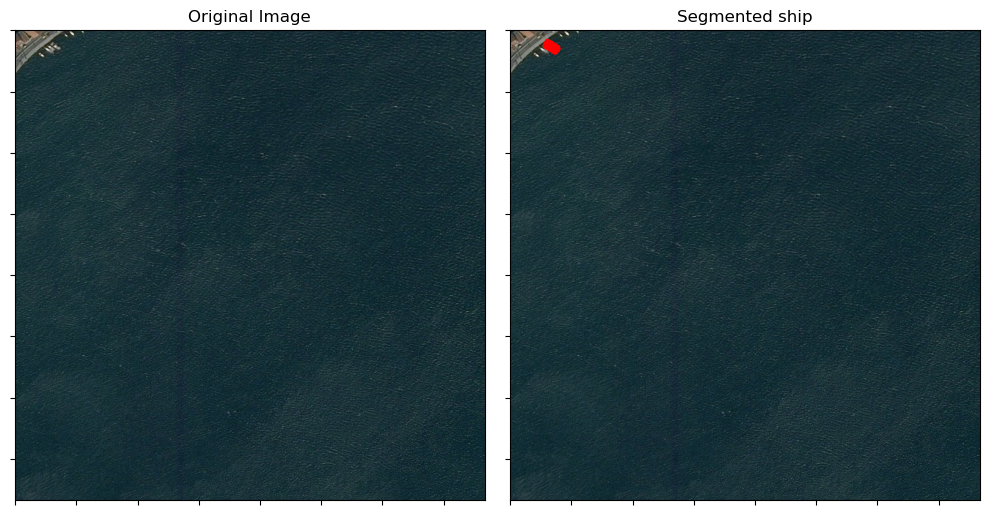

In [176]:
plot_image(52192)

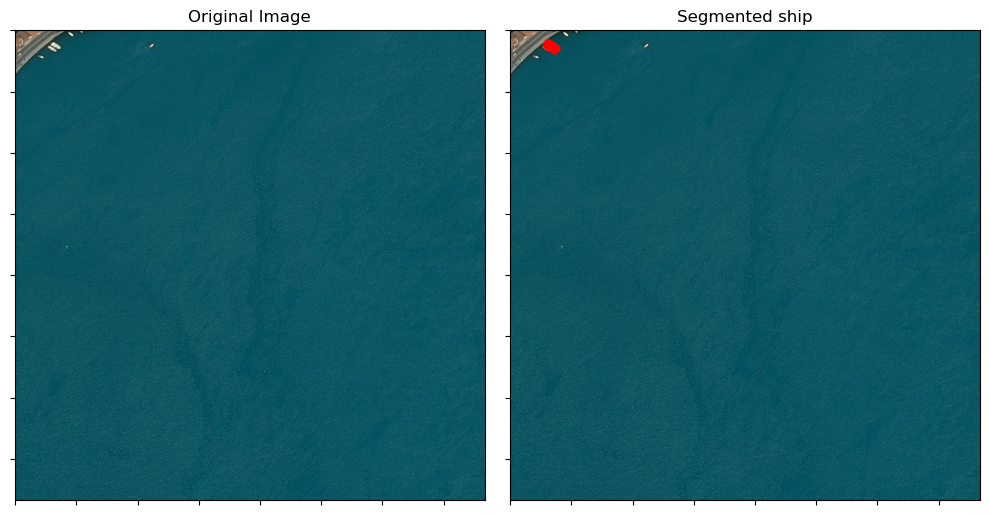

In [177]:
plot_image(158723)

### 1.4 Distribution of ships

In [288]:
df_unique_images = df.copy()
df_unique_images['EncodedPixels'] = df_unique_images['EncodedPixels'].fillna('')
df_unique_images['NumShips'] = df_unique_images.groupby('ImageId')['ImageId'].transform('count')
df_unique_images.loc[df_unique_images['EncodedPixels'] == '', 'NumShips'] = 0
df_unique_images = df_unique_images.drop_duplicates(subset=['ImageId'])
print(df_unique_images)


              ImageId                                      EncodedPixels  \
0       00003e153.jpg                                                      
1       0001124c7.jpg                                                      
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
8       0001b1832.jpg                                                      
...               ...                                                ...   
231718  fffedbb6b.jpg                                                      
231719  ffff2aa57.jpg                                                      
231720  ffff6e525.jpg                                                      
231721  ffffc50b4.jpg                                                      
231722  ffffe97f3.jpg                                                      

        NumShips  
0              0  
1              0  
2              1  
3          

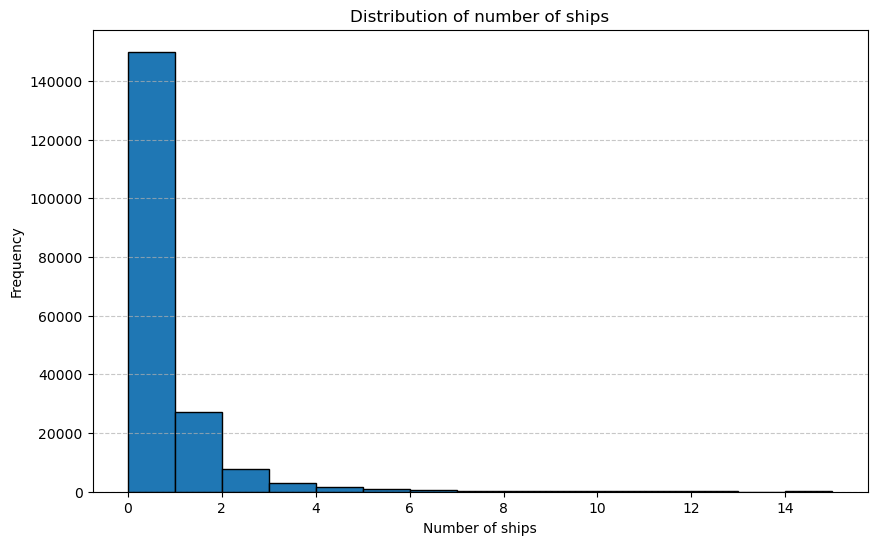

In [291]:
plt.figure(figsize=(10, 6))
plt.hist(df_unique_images['NumShips'], bins=max(df_unique_images['NumShips']), edgecolor='black')
plt.title(f'Distribution of number of ships')
plt.xlabel('Number of ships')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2. Summary

Having done dataset observation I have come to the conclusions:<br>
- The data is well structured into 3 main categories: test images, train images and csv segmentation file
- Segmentation is "ground-truth" type encoded in run-length encoding which were easy to decode
- The images are all the same size and dimension which is good
- There are duplicates in ImageId. In this case it means that each ship has its own image and one image may contain many ships
- There is one duplication in Encoded Pixels column and it doesn't affect our dataset
- ~65% of the data is images without ships. Images with more than one ship: 15452. Images with one ship: 27104
- For good results we need undersample the data

## 3. Data preprocessing

### 3.1 Undersampling data
Firstly lets split it 40/40/20 so the model would know when there is no ships, know how to identify one ship and be aware that there could be more than one ship. So it would be approximately ~38% images with no ships, ~40% images with one ship and ~22% images with more than one ship

In [300]:
# Let one ship sample be ~40% of our undersampled dataset, then more than one ship is ~22% and the rest ~38% is no ship samples
# in conclusion one ship sample is 27104, more than one ship is 15452, no ship sample is 26112
no_ships_samples = 26112
one_ship_samples = 27104
more_than_one_ship_samples = 15452

undersampled_no_ships = df_unique_images[df_unique_images['NumShips'] == 0].sample(no_ships_samples)
undersampled_one_ship = df_unique_images[df_unique_images['NumShips'] == 1].sample(one_ship_samples)
undersampled_more_than_one_ship = df_unique_images[df_unique_images['NumShips'] > 1].sample(more_than_one_ship_samples)

undersampled_df = pd.concat([undersampled_no_ships, undersampled_one_ship, undersampled_more_than_one_ship])

undersampled_df = undersampled_df.sample(frac=1).reset_index(drop=True)

print(undersampled_df)

             ImageId                                      EncodedPixels  \
0      5f55ef176.jpg  490841 1 491608 3 492375 5 493142 7 493909 9 4...   
1      c8b000d67.jpg                                                      
2      6564c5a8a.jpg  12066 2 12834 4 13601 7 14369 10 15136 13 1590...   
3      213b21106.jpg                                                      
4      1abd998f8.jpg  404555 2 405321 4 406088 6 406856 6 407625 6 4...   
...              ...                                                ...   
68663  aafb4c448.jpg  295712 5 296480 9 297248 9 298016 9 298784 9 2...   
68664  a9589c03a.jpg  323561 1 324328 4 325096 5 325863 8 326630 10 ...   
68665  88c08aef8.jpg  418729 1 419496 3 420263 5 421029 7 421796 9 4...   
68666  b581e47a8.jpg                                                      
68667  96722aec2.jpg  500553 3 501317 7 502083 9 502851 10 503619 10...   

       NumShips  
0             1  
1             0  
2             1  
3             0  
4        

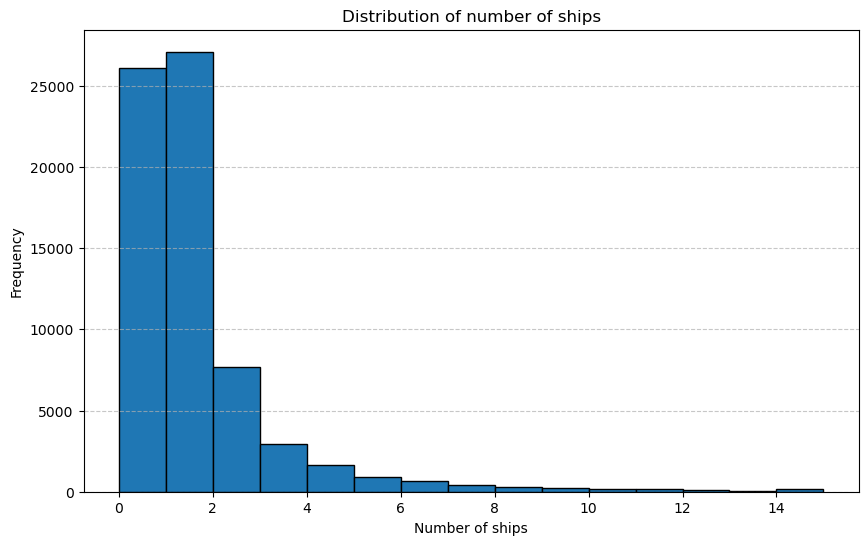

In [302]:
plt.figure(figsize=(10, 6))
plt.hist(undersampled_df['NumShips'], bins=max(undersampled_df['NumShips']), edgecolor='black')
plt.title(f'Distribution of number of ships')
plt.xlabel('Number of ships')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3.2 Creating segmented images for future augmentation
#### Combine masks into one image for same image ids
Firstly we need to create function that makes mask out of list given pixels<br>
Then we need to generate list of segmentation pixels for each image that has ships<br>
Lastly lets create dictionary where key is ImageId and value list of segmentation pixels

### 3.3 Data split
#### Split the training data the right way so train and val dataset has equal amount of 0 ship images and >0 ship images